### THUC HIEN TREN GG COLAB

Cai dat thu vien va giai nen file zip

In [ ]:
!unzip /content/vqa_coco_dataset.zip

In [ ]:
!pip install --upgrade jax jaxlib
!pip install bitsandbytes==0.41.1
!pip install -U bitsandbytes

khai bao thu vien

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import LlavaForConditionalGeneration
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from transformers import GenerationConfig
from PIL import Image

doc bo du lieu test

In [ ]:
test_data = []
test_set_path =  './vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
  lines = f.readlines()
  for line in lines:
    temp = line.split('\t')
    qa = temp[1].split('?')

    if len(qa) == 3:
      answer = qa[2].strip()
    else:
      answer = qa[1].strip()

    data_sample = {
        'image_path': temp[0][:-2],
        'question': qa[0] + '?',
        'answer': answer
    }
    test_data.append(data_sample)


khai bao mo hinh VLM

In [ ]:
quantization_config = BitsAndBytesConfig(
  load_in_4bit =True,
  bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
  model_id,
  quantization_config=quantization_config,
  device_map=device
)

xay dung ham tao prompt

In [ ]:
def create_prompt (question):
  prompt = f""" ### INSTRUCTION:
Your task is to answer the question based on the given image. You can only answer 'yes' or 'no'.
### USER: <image>
{question}
### ASSISTANT:"""
  return prompt

khai bao cac tham so tao sinh

In [ ]:
generation_config = GenerationConfig(
  max_new_token=10,
  do_sample=True,
  temperature=0.1,
  top_p=0.95,
  top_k=50,
  eos_token_id=model.config.eos_token_id,
  pad_token=model.config.pad_token_id,
)


thuc hien du doan

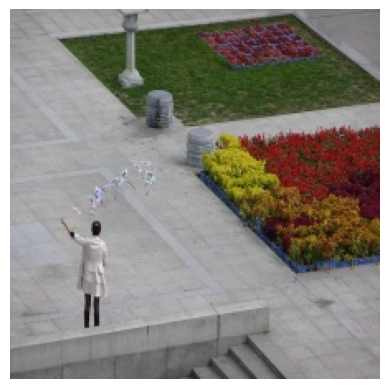

Question: Is this a skate park ?
Label: no
Prediction: No


In [ ]:
idx = 14
question = test_data[idx]['question']
image_name = test_data[idx]['image_path']
image_path = os.path.join('val2014-resised', image_name)
label = test_data[idx]['answer']
image = Image.open(image_path)

prompt = create_prompt(question)
inputs = processor(prompt,
                   image,
                   padding=True,
                   return_tensors="pt").to(device)

output = model.generate(**inputs, generation_config=generation_config)
generated_text = processor.decode(output[0], skip_special_tokens =True)

plt.imshow(image)
plt.axis("off")
plt.show()
print (f"Question: {question}")
print (f"Label: {label}")
print (f"Prediction: {generated_text.split('### ASSISTANT: ')[-1]}")
